In [16]:
%pip install open_clip_torch

In [2]:
import os
import json
import torch
from PIL import Image
import open_clip
import tarfile

In [18]:
# Í≤ΩÎ°ú ÏÑ§Ï†ï
origin_folder = 'Laion_origin'
output_folder = 'Laion_imgs'

# Ï∂úÎ†• Ìè¥ÎçîÍ∞Ä ÏóÜÏúºÎ©¥ ÏÉùÏÑ±
os.makedirs(output_folder, exist_ok=True)

# 00101.tar ~ 00200.tarÍπåÏßÄ Î∞òÎ≥µ
for i in range(108, 130):
    tar_name = f"{i:05d}.tar"
    tar_path = os.path.join(origin_folder, tar_name)

    if os.path.exists(tar_path):
        print(f"Extracting {tar_name}...")
        try:
            with tarfile.open(tar_path, 'r') as tar:
                tar.extractall(path=output_folder)
        except Exception as e:
            print(f"Error extracting {tar_name}: {e}")
    else:
        print(f"{tar_name} not found!")

Extracting 00108.tar...
Error extracting 00108.tar: [Errno 13] Permission denied: 'Laion_imgs\\001080117.jpg'
Extracting 00109.tar...
Error extracting 00109.tar: [Errno 13] Permission denied: 'Laion_imgs\\001090000.jpg'
Extracting 00110.tar...
Error extracting 00110.tar: [Errno 13] Permission denied: 'Laion_imgs\\001100002.jpg'
Extracting 00111.tar...
Error extracting 00111.tar: [Errno 13] Permission denied: 'Laion_imgs\\001110000.jpg'
Extracting 00112.tar...
Error extracting 00112.tar: [Errno 13] Permission denied: 'Laion_imgs\\001120207.jpg'
Extracting 00113.tar...
Error extracting 00113.tar: [Errno 13] Permission denied: 'Laion_imgs\\001130244.jpg'
Extracting 00114.tar...
Error extracting 00114.tar: [Errno 13] Permission denied: 'Laion_imgs\\001140143.jpg'
Extracting 00115.tar...
Error extracting 00115.tar: [Errno 13] Permission denied: 'Laion_imgs\\001150003.jpg'
Extracting 00116.tar...
Error extracting 00116.tar: [Errno 13] Permission denied: 'Laion_imgs\\001160086.jpg'
Extracting

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [19]:
# Î™®Îç∏ Î∞è Î≥ÄÌôòÍ∏∞ Ï¥àÍ∏∞Ìôî
model, _, preprocess_val = open_clip.create_model_and_transforms(
    'hf-hub:timm/vit_base_patch16_clip_224.laion400m_e32'
)
tokenizer = open_clip.get_tokenizer(
    'hf-hub:timm/vit_base_patch16_clip_224.laion400m_e32'
)

# Ïù¥ÎØ∏ÏßÄ Ìè¥Îçî Í≤ΩÎ°ú ÏÑ§Ï†ï
image_folder = r"Laion_imgs"

def classify_images(folder_path):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    # ÏÇ¨Ïö©Ìï† ÎùºÎ≤® Ï†ïÏùò
    labels = [
        "accessories, products, hiking", "diagrams", "appliances", "outdoors, sea, sky", "products, cups, lamps, plates, candles",
        "book covers", "product photos, chairs, furniture", "text, buttons, cartoons (with text)", "person", "video game graphics",
        "toys, stuffed animals, cartoon characters", "outdoors, trees, mountains, nature", "screenshots, graphics, phone, desktop", "cars, racing", "sports",
        "outside, buildings", "jewelry, bracelet, necklace, ring, earring", "movie posters, tv shows, DVDs", "jackets, shirts, product photos", "christmas",
        "gadgets, electronics, laptops", "people on tv, movies", "people, crowds, crowded", "tires, bikes, vehicles", "food",
        "industrial, equipment", "historical photos, black and white", "holiday, flowers, wedding, birthday, cake", "political photos", "backgrounds, textures",
        "shoes, footwear, belts", "album covers", "product packaging", "weddings, wedding dress, wedding photography, couples", "sports footage",
        "celebrities", "text, book covers", "makeup, perfume, product", "sexy, porn", "travel, destinations, famous buildings",
        "normal cars", "cellphones, cellphone cases", "video game covers, comic books, superheroes", "girl, family, baby, people", "invitations, events, venues",
        "art, paintings, frames", "clothing, models, product photography", "parts, tools", "posters, ads, book covers, movies", "flowers, garden, plants",
        "vehicles - trains, planes, trucks, heavy equipment, satellites", "text, forms, documents, sheet music", "business, graphics, infographics, presentations", "signs, products",
        "shorts, pants, skirts, product photography", "Indian", "animals", "watches clocks, time, timepieces", "drinks, bottles, alcohol",
        "people, text", "text, graphs, study materials", "interior, furniture, bedroom, bathroom, bed, sofa", "logos, stickers, graphics", "products, shirts, hats"
    ]

    text_inputs = tokenizer(labels)
    text_inputs = text_inputs.to(device)
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert("RGB")
            image = preprocess_val(image).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                image_features /= image_features.norm(dim=-1, keepdim=True)

                similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
                top_label = labels[similarity.argmax().item()]

                result = {"label": top_label}
                json_path = os.path.join(folder_path, filename.replace(".jpg", "_result.json"))
                with open(json_path, "w", encoding="utf-8") as f:
                    json.dump(result, f, ensure_ascii=False, indent=4)

                print(f"Processed {filename}: {top_label}")

if __name__ == "__main__":
    classify_images(image_folder)


Processed 001080020.jpg: sports
Processed 001080029.jpg: signs, products
Processed 001080055.jpg: person
Processed 001080087.jpg: album covers
Processed 001080117.jpg: food
Processed 001080136.jpg: person
Processed 001080138.jpg: tires, bikes, vehicles
Processed 001080139.jpg: person
Processed 001080145.jpg: sports
Processed 001080146.jpg: sports
Processed 001080148.jpg: sports
Processed 001080151.jpg: sports
Processed 001080156.jpg: book covers
Processed 001080206.jpg: sports
Processed 001080227.jpg: logos, stickers, graphics
Processed 001080231.jpg: person
Processed 001080236.jpg: backgrounds, textures
Processed 001080243.jpg: person
Processed 001080249.jpg: sports
Processed 001080256.jpg: person
Processed 001080266.jpg: movie posters, tv shows, DVDs
Processed 001080278.jpg: christmas
Processed 001080281.jpg: person
Processed 001080282.jpg: sports
Processed 001080283.jpg: flowers, garden, plants
Processed 001080300.jpg: sports
Processed 001080310.jpg: sports
Processed 001080338.jpg: 

KeyboardInterrupt: 

In [2]:
import os
import json
import torch
from PIL import Image
import open_clip
from collections import Counter

class ImageClassifier:
    def __init__(self, model_name, labels, image_folder):
        self.model_name = model_name
        self.labels = labels
        self.image_folder = image_folder
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Î™®Îç∏ Î∞è Î≥ÄÌôòÍ∏∞ Ï¥àÍ∏∞Ìôî
        self.model, _, self.preprocess_val = open_clip.create_model_and_transforms(self.model_name)
        self.tokenizer = open_clip.get_tokenizer(self.model_name)
        self.model.to(self.device)
        self.model.eval()

    def classify_images(self):
        text_inputs = self.tokenizer(self.labels)
        text_inputs = text_inputs.to(self.device)
        text_features = self.model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        for filename in os.listdir(self.image_folder):
            if filename.endswith(".jpg"):
                image_path = os.path.join(self.image_folder, filename)
                with Image.open(image_path).convert("RGB") as img:
                    image = self.preprocess_val(img).unsqueeze(0).to(self.device)
                # image = self.preprocess_val(image).unsqueeze(0).to(self.device)

                with torch.no_grad():
                    image_features = self.model.encode_image(image)
                    image_features /= image_features.norm(dim=-1, keepdim=True)

                    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
                    top_label = self.labels[similarity.argmax().item()]

                    result = {"label": top_label}
                    json_path = os.path.join(self.image_folder, filename.replace(".jpg", "_result.json"))
                    with open(json_path, "w", encoding="utf-8") as f:
                        json.dump(result, f, ensure_ascii=False, indent=4)

                    print(f"Processed {filename}: {top_label}")
        return self.image_folder


class LabelRemover:
    def __init__(self, image_folder):
        self.image_folder = image_folder

    def safe_remove(self, path):
        import stat
        import time
        import gc

        try:
            if os.path.exists(path):
                os.chmod(path, stat.S_IWRITE)
                gc.collect()
                time.sleep(0.1)
                os.remove(path)
                print(f"Deleted: {path}")
        except PermissionError as e:
            print(f"[PermissionError] {path} ÏÇ≠Ï†ú Ïã§Ìå®: {e}")
        except Exception as e:
            print(f"[Error] {path} ÏÇ≠Ï†ú Ïã§Ìå®: {e}")

    def remove_indian_labeled_images(self):
        for filename in os.listdir(self.image_folder):
            if filename.endswith("_result.json"):
                json_path = os.path.join(self.image_folder, filename)

                with open(json_path, 'r', encoding='utf-8') as f:
                    result = json.load(f)

                if result["label"] == "Indian":
                    image_path = os.path.join(self.image_folder, filename.replace("_result.json", ".jpg"))
                    txt_path = os.path.join(self.image_folder, filename.replace("_result.json", ".txt"))
                    original_json_path = os.path.join(self.image_folder, filename.replace("_result.json", ".json"))

                    self.safe_remove(image_path)
                    self.safe_remove(json_path)
                    self.safe_remove(txt_path)
                    self.safe_remove(original_json_path)



class LabelCounter:
    def __init__(self, image_folder):
        self.image_folder = image_folder

    def count_labels(self):
        label_counter = Counter()

        for filename in os.listdir(self.image_folder):
            if filename.endswith("_result.json"):
                json_path = os.path.join(self.image_folder, filename)

                # JSON ÌååÏùº ÏùΩÍ∏∞
                with open(json_path, 'r', encoding='utf-8') as f:
                    result = json.load(f)

                # ÎùºÎ≤® Ïπ¥Ïö¥Ìä∏
                label = result["label"]
                label_counter[label] += 1

        # ÎùºÎ≤®Î≥Ñ Í∞úÏàò Ï∂úÎ†•
        for label, count in label_counter.items():
            print(f"Label: {label}, Count: {count}")


if __name__ == "__main__":

    image_folder = r"Laion_imgs"

    remover = LabelRemover(image_folder=image_folder)
    remover.remove_indian_labeled_images()


    # ÎùºÎ≤® Ïπ¥Ïö¥Ìä∏
    counter = LabelCounter(image_folder=image_folder)
    counter.count_labels()


Deleted: Laion_imgs\001083214.jpg
Deleted: Laion_imgs\001083214_result.json
Deleted: Laion_imgs\001083214.txt
Deleted: Laion_imgs\001083214.json
Deleted: Laion_imgs\001083215.jpg
Deleted: Laion_imgs\001083215_result.json
Deleted: Laion_imgs\001083215.txt
Deleted: Laion_imgs\001083215.json
Deleted: Laion_imgs\001083221.jpg
Deleted: Laion_imgs\001083221_result.json
Deleted: Laion_imgs\001083221.txt
Deleted: Laion_imgs\001083221.json
Deleted: Laion_imgs\001083232.jpg
Deleted: Laion_imgs\001083232_result.json
Deleted: Laion_imgs\001083232.txt
Deleted: Laion_imgs\001083232.json
Deleted: Laion_imgs\001083233.jpg
Deleted: Laion_imgs\001083233_result.json
Deleted: Laion_imgs\001083233.txt
Deleted: Laion_imgs\001083233.json
Deleted: Laion_imgs\001083242.jpg
Deleted: Laion_imgs\001083242_result.json
Deleted: Laion_imgs\001083242.txt
Deleted: Laion_imgs\001083242.json
Deleted: Laion_imgs\001083266.jpg
Deleted: Laion_imgs\001083266_result.json
Deleted: Laion_imgs\001083266.txt
Deleted: Laion_imgs\

KeyboardInterrupt: 

In [4]:
import os
import json
import shutil

class LabelBasedOrganizer:
    def __init__(self, base_folder):
        self.base_folder = base_folder

    def organize_by_label(self):
        for filename in os.listdir(self.base_folder):
            if not filename.endswith("_result.json"):
                continue

            result_path = os.path.join(self.base_folder, filename)

            # JSON Ïó¥Í∏∞
            with open(result_path, 'r', encoding='utf-8') as f:
                result = json.load(f)

            label = result.get("label")
            if not label:
                print(f"[Í≤ΩÍ≥†] ÎùºÎ≤®Ïù¥ ÏóÜÎäî ÌååÏùº: {filename}")
                continue

            prefix = filename.replace("_result.json", "")
            label_folder = os.path.join(self.base_folder, label)

            # ÎùºÎ≤® Ìè¥ÎçîÍ∞Ä ÏóÜÎã§Î©¥ ÏÉùÏÑ±
            os.makedirs(label_folder, exist_ok=True)

            # Í¥ÄÎ†®Îêú Î™®Îì† ÌååÏùº Ïù¥Îèô (.jpg, .json, .txt, _result.json)
            for ext in [".jpg", ".json", ".txt", "_result.json"]:
                src = os.path.join(self.base_folder, f"{prefix}{ext}")
                dst = os.path.join(label_folder, f"{prefix}{ext}")
                if os.path.exists(src):
                    try:
                        if os.path.exists(dst):
                            os.remove(dst)  # Í∏∞Ï°¥ ÌååÏùº ÏÇ≠Ï†ú
                        shutil.move(src, dst)
                        print(f"Moved {src} ‚Üí {dst}")
                    except Exception as e:
                        print(f"[Ïò§Î•ò] {src} Ïù¥Îèô Ïã§Ìå®: {e}")


In [5]:
import re

def sanitize_filename(name):
    # ÏúàÎèÑÏö∞ Î∂àÍ∞ÄÎä• Î¨∏Ïûê Ï†úÍ±∞ / -> _, : -> -, etc
    return re.sub(r'[<>:"/\\|?*]', '_', name)

## Data Î∂ÑÎ∞∞

In [10]:
import os
import shutil
import random
from collections import defaultdict

LABEL_DIR = "Laion_imgs"
CLIENT_ROOT = "clients"
NUM_CLIENTS = 20
LABELS_PER_CLIENT = 9
TOTAL_IMAGES_PER_CLIENT = 500
OVERLAP_LABELS = 4

random.seed(42)

# Î™®Îì† ÎùºÎ≤® Ìè¥Îçî
all_labels = [folder for folder in os.listdir(LABEL_DIR) if os.path.isdir(os.path.join(LABEL_DIR, folder))]
random.shuffle(all_labels)

# ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏Î≥Ñ ÎùºÎ≤® ÏÖã Ìï†Îãπ
client_labels = defaultdict(set)

# 1. ÎùºÎ≤®ÏùÑ Í≤πÏπòÍ≤å Ìï†Îãπ
for i in range(NUM_CLIENTS):
    client_labels[i] = set(random.sample(all_labels, LABELS_PER_CLIENT))

# ÎùºÎ≤® Í≤πÏπòÍ∏∞
for i in range(NUM_CLIENTS - 1):
    shared = random.sample(list(client_labels[i]), OVERLAP_LABELS)
    client_labels[i + 1].update(shared)

# 2. ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏Î≥ÑÎ°ú Îç∞Ïù¥ÌÑ∞ Î≥µÏÇ¨
os.makedirs(CLIENT_ROOT, exist_ok=True)

for cid in range(NUM_CLIENTS):
    client_path = os.path.join(CLIENT_ROOT, f"client_{cid}")
    os.makedirs(client_path, exist_ok=True)

    print(f"üì¶ Client {cid} ÎùºÎ≤®: {client_labels[cid]}")
    images_copied = 0
    used_labels = list(client_labels[cid])
    random.shuffle(used_labels)

    for label in used_labels:
        label_path = os.path.join(LABEL_DIR, label)
        if not os.path.isdir(label_path):
            continue

        files = [f for f in os.listdir(label_path) if f.endswith(".jpg")]
        random.shuffle(files)
        count = 0
        for img_file in files:
            base = img_file.replace(".jpg", "")
            group = [f"{base}.jpg", f"{base}.txt"]
            if all(os.path.exists(os.path.join(label_path, f)) for f in group):
                # üëâ ÎùºÎ≤® Ïù¥Î¶Ñ Ï†ïÏ†ú Ï†ÅÏö©
                safe_label = sanitize_filename(label)
                dst_dir = os.path.join(client_path, safe_label)
                os.makedirs(dst_dir, exist_ok=True)
                for f in group:
                    src = os.path.join(label_path, f)
                    dst = os.path.join(dst_dir, f)
                    shutil.copy(src, dst) # Ïù¥ÎØ∏ Ï°¥Ïû¨ÌïòÎ©¥ Permission error - Ïã†Í≤Ω Ïïà Ïç®ÎèÑ ok
                count += 1
                images_copied += 1
                if images_copied >= TOTAL_IMAGES_PER_CLIENT:
                    break
        if images_copied >= TOTAL_IMAGES_PER_CLIENT:
            break



üì¶ Client 0 ÎùºÎ≤®: {'video game graphics', 'toys, stuffed animals, cartoon characters', 'celebrities', 'historical photos, black and white', 'backgrounds, textures', 'weddings, wedding dress, wedding photography, couples', 'video game covers, comic books, superheroes', 'product photos, chairs, furniture', 'signs, products'}


PermissionError: [Errno 13] Permission denied: 'clients\\client_0\\video game covers, comic books, superheroes\\001286453.jpg'

## ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏ ÎÇ¥ Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÌï†(training/ validation/ test)

In [ ]:
def split_dataset(client_dir):
    for label in os.listdir(client_dir):
        label_path = os.path.join(client_dir, label)
        if not os.path.isdir(label_path):
            continue
        files = sorted([f for f in os.listdir(label_path) if f.endswith(".jpg")])
        random.shuffle(files)

        total = len(files)
        train_end = int(total * 0.7)
        val_end = int(total * 0.85)

        for idx, f in enumerate(files):
            base = f.replace(".jpg", "")
            dest = "train" if idx < train_end else "val" if idx < val_end else "test"
            target_path = os.path.join(client_dir, dest, label)
            os.makedirs(target_path, exist_ok=True)

            for ext in [".jpg", ".txt"]:
                shutil.move(
                    os.path.join(label_path, f"{base}{ext}"),
                    os.path.join(target_path, f"{base}{ext}")
                )
        shutil.rmtree(label_path)

# ÏòàÏãú: Î™®Îì† ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
for i in range(NUM_CLIENTS):
    split_dataset(os.path.join(CLIENT_ROOT, f"client_{i}"))


## Ìä∏ÎûúÏä§Ìè¨Î®∏ ÏÑ§Ïπò

In [1]:
!pip install torch==2.5.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers==4.40.2
!pip install accelerate
!pip install scikit-learn
!pip install seaborn

Looking in indexes: https://download.pytorch.org/whl/cu121


  Using cached transformers-4.40.2-py3-none-any.whl.metadata (137 kB)
  Using cached tokenizers-0.19.1-cp310-none-win_amd64.whl.metadata (6.9 kB)
Using cached transformers-4.40.2-py3-none-any.whl (9.0 MB)
Using cached tokenizers-0.19.1-cp310-none-win_amd64.whl (2.2 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1


## Î°úÏª¨ Î™®Îç∏ Ï†ïÏùò + ÌïôÏäµ

In [69]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

In [70]:
!pip show torch

Name: torch
Version: 2.5.1+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\users\user\miniconda3\envs\laion_env\lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, open_clip_torch, timm, torchaudio, torchvision


In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### multimodal dataset

In [72]:
# ---------------------------
# 1. Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÏùò
class MultiModalDataset(Dataset):
    def __init__(self, root, tokenizer, transform, label2idx):
        self.samples = []
        self.transform = transform
        self.tokenizer = tokenizer
        self.label2idx = label2idx

        for label in os.listdir(root):
            label_path = os.path.join(root, label)
            if not os.path.isdir(label_path):
                continue
            for fname in os.listdir(label_path):
                if fname.endswith(".jpg"):
                    base = fname[:-4]
                    txt_path = os.path.join(label_path, f"{base}.txt")
                    img_path = os.path.join(label_path, f"{base}.jpg")
                    if os.path.exists(txt_path):
                        self.samples.append((img_path, txt_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, txt_path, label = self.samples[idx]
        image = self.transform(Image.open(img_path).convert("RGB"))

        with open(txt_path, 'r', encoding='utf-8') as f:
            text = f.read()

        encoded = self.tokenizer(text, truncation=True, padding='max_length', max_length=32, return_tensors="pt")
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)

        label_idx = self.label2idx[label]
        return image, input_ids, attention_mask, torch.tensor(label_idx)

In [73]:
# ---------------------------
# 2. Ïù∏ÏΩîÎçî Ï†ïÏùò
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.mobilenet_v3_small(pretrained=True)
        self.features = model.features  # Ïù¥Í±¥ [B, 576, H, W]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # üî• Íº≠ ÌïÑÏöî!
        self.output_dim = 576

    def forward(self, x):
        x = self.features(x)          # ‚Üí [B, 576, H, W]
        x = self.avgpool(x)           # ‚Üí [B, 576, 1, 1]
        x = torch.flatten(x, 1)       # ‚Üí [B, 576]
        return x

class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("prajjwal1/bert-tiny")
        self.output_dim = self.bert.config.hidden_size

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return output.pooler_output


In [74]:
CLIENT_MODALITY = {
    "image_only": [0, 1],
    "text_only": [2, 3],
    "both": [4, 5, 6, 7, 8, 9]
}

### fusion classifier

In [75]:
# ---------------------------
# 3. Î©ÄÌã∞Î™®Îã¨ Î∂ÑÎ•òÍ∏∞
class FusionClassifier(nn.Module):
    def __init__(self, fusion_input_dim, hidden_dim, num_classes, use_img=True, use_txt=True):
        super().__init__()
        self.use_img = use_img
        self.use_txt = use_txt

        if use_img:
            self.img_encoder = ImageEncoder()
        if use_txt:
            self.txt_encoder = TextEncoder()

        self.fc_fusion = nn.Linear(fusion_input_dim, hidden_dim)
        self.forget_gate = nn.Linear(hidden_dim, hidden_dim)
        self.input_gate = nn.Linear(fusion_input_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, image, input_ids=None, attention_mask=None, prev_z=None):
        reps = []

        if self.use_img and image is not None:
            R_img = self.img_encoder(image)
            reps.append(R_img)

        if self.use_txt and input_ids is not None and attention_mask is not None:
            R_txt = self.txt_encoder(input_ids, attention_mask)
            reps.append(R_txt)

        if not reps:
            raise ValueError("[ERROR] No input modality was provided.")

        # repsÍ∞Ä ÎπÑÏñ¥ÏûàÏßÄ ÏïäÏùÄ Í≤ΩÏö∞ÏóêÎßå ÏßÑÌñâ
        R = torch.cat(reps, dim=1)

        # ÎîîÎ≤ÑÍπÖ Ï∂îÍ∞Ä
        # print(f"[DEBUG] use_img={self.use_img}, use_txt={self.use_txt}, R.shape={R.shape}, fc_in={self.fc_fusion.in_features}")
        assert R.shape[1] == self.fc_fusion.in_features, \
            f"[ERROR] Fusion input dim mismatch: R.shape={R.shape}, fc expects {self.fc_fusion.in_features}"

        R_prime = torch.tanh(self.fc_fusion(R))
        F_t = torch.sigmoid(self.forget_gate(prev_z))
        I_t = torch.sigmoid(self.input_gate(R))
        Z_t = F_t * prev_z + I_t * R_prime

        # print(f"[DEBUG] use_img={self.use_img}, use_txt={self.use_txt}, reps={[r.shape for r in reps]}")

        return self.classifier(Z_t), Z_t


## ÌïôÏäµ Î£®ÌîÑ Î∞è ÌèâÍ∞Ä

In [76]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for image, input_ids, attention_mask, labels in dataloader:
        image, input_ids, attention_mask, labels = image.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
        batch_size = image.size(0)
        prev_z = torch.zeros(batch_size, model.classifier.in_features).to(device)

        optimizer.zero_grad()
        output, _ = model(image, input_ids, attention_mask, prev_z)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (output.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for image, input_ids, attention_mask, labels in dataloader:
            image, input_ids, attention_mask, labels = image.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
            batch_size = image.size(0)
            prev_z = torch.zeros(batch_size, model.classifier.in_features).to(device)

            output, _ = model(image, input_ids, attention_mask, prev_z)
            loss = criterion(output, labels)

            total_loss += loss.item()
            correct += (output.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total


## ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏ Î∞òÎ≥µÎ¨∏ÏúºÎ°ú ÌïôÏäµÏãúÌÇ§Í∏∞

In [77]:
import json
import os

CLIENT_ROOT = "clients"
NUM_CLIENTS = 10
EPOCHS = 5
best_val_acc = 0

def train_all_clients():
    for i in range(NUM_CLIENTS):
        print(f"\nüì¶ Training Client {i}")
        client_path = os.path.join(CLIENT_ROOT, f"client_{i}")

        # modality Í≤∞Ï†ï
        if i in CLIENT_MODALITY["image_only"]:
            use_img, use_txt = True, False
        elif i in CLIENT_MODALITY["text_only"]:
            use_img, use_txt = False, True
        else:
            use_img, use_txt = True, True

        # ÎùºÎ≤® Îß§Ìïë
        labels = sorted([l for l in os.listdir(os.path.join(client_path, "train"))
                         if os.path.isdir(os.path.join(client_path, "train", l))])
        label2idx = {label: idx for idx, label in enumerate(labels)}
        num_classes = len(label2idx)

        # Îç∞Ïù¥ÌÑ∞ÏÖã
        train_ds = MultiModalDataset(os.path.join(client_path, "train"), tokenizer, transform, label2idx)
        val_ds = MultiModalDataset(os.path.join(client_path, "val"), tokenizer, transform, label2idx)

        train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=16)

        fusion_input_dim = 0
        if use_img:
            fusion_input_dim += 576
        if use_txt:
            fusion_input_dim += 128

        model = FusionClassifier(
            fusion_input_dim=fusion_input_dim,
            hidden_dim=256,
            num_classes=num_classes,
            use_img=use_img,
            use_txt=use_txt
        ).to(device)
        print(f"[Client {i}] use_img={use_img}, use_txt={use_txt}, fusion_input_dim={fusion_input_dim}")

        # Î™®Îç∏ Ï¥àÍ∏∞Ìôî
        # model = FusionClassifier(576, 128, 256, num_classes, use_img=use_img, use_txt=use_txt).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
        criterion = nn.CrossEntropyLoss()

        client_log = []
        # ÌïôÏäµ Î£®ÌîÑ
        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
            val_loss, val_acc = evaluate(model, val_loader, criterion)
            print(f"Client {i} Epoch {epoch+1} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            client_log.append({
                "epoch": epoch+1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })

            # Í∞ÄÏû• ÎÜíÏùÄ val_acc Î™®Îç∏ÏùÑ Ï†ÄÏû•
            if epoch == 0 or val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()

        # ‚úÖ ÏµúÏ¢Ö best Î™®Îç∏ Ï†ÄÏû•
        torch.save(best_model_state, os.path.join(client_path, "best_model.pt"))

        with open(os.path.join(client_path, f"training_results.json"), "w", encoding="utf-8") as f:
            json.dump(client_log, f, indent=2)


In [78]:
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [79]:
train_all_clients()


üì¶ Training Client 0
[Client 0] use_img=True, use_txt=False, fusion_input_dim=576
Client 0 Epoch 1 | Train Loss: 0.6517 Acc: 0.7557 | Val Loss: 0.3677 Acc: 0.8533
Client 0 Epoch 2 | Train Loss: 0.2681 Acc: 0.9138 | Val Loss: 0.1647 Acc: 0.9333
Client 0 Epoch 3 | Train Loss: 0.1214 Acc: 0.9626 | Val Loss: 0.1108 Acc: 0.9467
Client 0 Epoch 4 | Train Loss: 0.0675 Acc: 0.9885 | Val Loss: 0.0811 Acc: 0.9733
Client 0 Epoch 5 | Train Loss: 0.0558 Acc: 0.9914 | Val Loss: 0.0867 Acc: 0.9733

üì¶ Training Client 1
[Client 1] use_img=True, use_txt=False, fusion_input_dim=576
Client 1 Epoch 1 | Train Loss: 0.9236 Acc: 0.5702 | Val Loss: 0.7748 Acc: 0.6267
Client 1 Epoch 2 | Train Loss: 0.5402 Acc: 0.8309 | Val Loss: 0.4901 Acc: 0.8267
Client 1 Epoch 3 | Train Loss: 0.2607 Acc: 0.9169 | Val Loss: 0.3921 Acc: 0.8533
Client 1 Epoch 4 | Train Loss: 0.1256 Acc: 0.9685 | Val Loss: 0.4681 Acc: 0.8133
Client 1 Epoch 5 | Train Loss: 0.0790 Acc: 0.9799 | Val Loss: 0.4945 Acc: 0.8000

üì¶ Training Clien

## Extract Representation Vectors

In [80]:
from transformers import AutoTokenizer, AutoModel
from torchvision import models, transforms
from PIL import Image
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import torch.nn.functional as F
import numpy as np
from glob import glob

## Load MiniBERT and MobileNet

In [81]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
text_model = AutoModel.from_pretrained("prajjwal1/bert-mini").to(device).eval()
text_tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-mini")

weights = MobileNet_V2_Weights.DEFAULT
img_model = mobilenet_v2(weights=weights).features.to(device).eval()
img_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

## ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏Î≥Ñ representation vector Ï∂îÏ∂ú

In [82]:
# LAION400B Í≥µÌÜµ Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨
LAION_DIR = "Laion_imgs"

# ÎûúÎç§ ÏÉòÌîåÎßÅ ÏÑ§Ï†ï
SAMPLE_SIZE = 500      # Ï†ÑÏ≤¥ÏóêÏÑú 500Í∞úÎßå ÎûúÎç§ ÏÉòÌîåÎßÅ (ÏãúÍ∞Ñ Îã®Ï∂ï)
BATCH_SIZE = 16        # Î∞∞Ïπò ÌÅ¨Í∏∞ (GPU Î©îÎ™®Î¶¨Ïóê ÎßûÍ≤å Ï°∞Ï†ï)
TARGET_DIM = 512       # Í≥µÌÜµ Ï∞®Ïõê

print("ÌååÏùº Î™©Î°ù ÏàòÏßë Ï§ë...")
img_files = sorted(glob(os.path.join(LAION_DIR, "*.jpg")))
print(f"Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ ÌååÏùº: {len(img_files)}Í∞ú")

# ÎûúÎç§ ÏÉòÌîåÎßÅ
if len(img_files) > SAMPLE_SIZE:
    sampled_files = random.sample(img_files, SAMPLE_SIZE)
    print(f"ÎûúÎç§ ÏÉòÌîåÎßÅ: {SAMPLE_SIZE}Í∞ú ÏÑ†ÌÉù")
else:
    sampled_files = img_files
    print(f"Ï†ÑÏ≤¥ ÌååÏùº ÏÇ¨Ïö©: {len(sampled_files)}Í∞ú")

# Ïú†Ìö®Ìïú ÌéòÏñ¥ ÌïÑÌÑ∞ÎßÅ
print("Ïú†Ìö®Ìïú Ïù¥ÎØ∏ÏßÄ-ÌÖçÏä§Ìä∏ ÌéòÏñ¥ ÌôïÏù∏ Ï§ë...")
valid_pairs = []

for img_path in sampled_files:
    txt_path = img_path.replace(".jpg", ".txt")
    if os.path.exists(txt_path):
        try:
            if os.path.getsize(img_path) > 0 and os.path.getsize(txt_path) > 0:
                valid_pairs.append((img_path, txt_path))
        except:
            continue

print(f"Ïú†Ìö®Ìïú ÌéòÏñ¥: {len(valid_pairs)}Í∞ú")

# Î∞∞ÏπòÎ≥Ñ Ï≤òÎ¶¨Î°ú representation Ï∂îÏ∂ú
image_reps, text_reps = [], []

for i in range(0, len(valid_pairs), BATCH_SIZE):
    print(f"Î∞∞Ïπò {i//BATCH_SIZE + 1}/{(len(valid_pairs)-1)//BATCH_SIZE + 1} Ï≤òÎ¶¨ Ï§ë...")

    batch_pairs = valid_pairs[i:i+BATCH_SIZE]
    img_batch, txt_batch = [], []

    # Î∞∞Ïπò Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    for img_path, txt_path in batch_pairs:
        try:
            # Ïù¥ÎØ∏ÏßÄ Î°úÎìú
            image = Image.open(img_path).convert("RGB")
            img_tensor = img_preprocess(image)
            img_batch.append(img_tensor)

            # ÌÖçÏä§Ìä∏ Î°úÎìú
            with open(txt_path, "r", encoding="utf-8") as f:
                text = f.read().strip()
            if text:
                txt_batch.append(text)
            else:
                img_batch.pop()  # Îπà ÌÖçÏä§Ìä∏Î©¥ Ïù¥ÎØ∏ÏßÄÎèÑ Ï†úÍ±∞

        except Exception as e:
            if len(img_batch) > len(txt_batch):
                img_batch.pop()
            continue

    if not img_batch or not txt_batch:
        continue

    try:
        # Ïù¥ÎØ∏ÏßÄ Î∞∞Ïπò Ï≤òÎ¶¨
        img_tensors = torch.stack(img_batch).to(device)
        with torch.no_grad():
            img_features = img_model(img_tensors).mean(dim=[2, 3])

            # Ï∞®Ïõê ÎßûÏ∂îÍ∏∞
            if img_features.shape[1] > TARGET_DIM:
                img_features = img_features[:, :TARGET_DIM]
            elif img_features.shape[1] < TARGET_DIM:
                padding = torch.zeros(img_features.shape[0], TARGET_DIM - img_features.shape[1]).to(device)
                img_features = torch.cat([img_features, padding], dim=1)

        # ÌÖçÏä§Ìä∏ Î∞∞Ïπò Ï≤òÎ¶¨
        tokens = text_tokenizer(txt_batch, return_tensors="pt", truncation=True,
                               padding=True, max_length=512).to(device)
        with torch.no_grad():
            txt_features = text_model(**tokens).last_hidden_state.mean(dim=1)

            # Ï∞®Ïõê ÎßûÏ∂îÍ∏∞
            if txt_features.shape[1] > TARGET_DIM:
                txt_features = txt_features[:, :TARGET_DIM]
            elif txt_features.shape[1] < TARGET_DIM:
                padding = torch.zeros(txt_features.shape[0], TARGET_DIM - txt_features.shape[1]).to(device)
                txt_features = torch.cat([txt_features, padding], dim=1)

        # CPUÎ°ú Ïù¥Îèô ÌõÑ Ï†ÄÏû•
        image_reps.extend(img_features.cpu())
        text_reps.extend(txt_features.cpu())

    except Exception as e:
        print(f"[Î∞∞Ïπò ÏóêÎü¨]: {e}")
        continue

# ÌÖêÏÑúÌôî
image_reps = torch.stack(image_reps)
text_reps = torch.stack(text_reps)

print(f"ÏµúÏ¢Ö Ï∂îÏ∂ú ÏôÑÎ£å:")
print(f"- Ïù¥ÎØ∏ÏßÄ representations: {image_reps.shape}")
print(f"- ÌÖçÏä§Ìä∏ representations: {text_reps.shape}")

ÌååÏùº Î™©Î°ù ÏàòÏßë Ï§ë...
Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ ÌååÏùº: 62053Í∞ú
ÎûúÎç§ ÏÉòÌîåÎßÅ: 500Í∞ú ÏÑ†ÌÉù
Ïú†Ìö®Ìïú Ïù¥ÎØ∏ÏßÄ-ÌÖçÏä§Ìä∏ ÌéòÏñ¥ ÌôïÏù∏ Ï§ë...
Ïú†Ìö®Ìïú ÌéòÏñ¥: 500Í∞ú
Î∞∞Ïπò 1/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 2/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 3/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 4/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 5/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 6/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 7/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 8/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 9/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 10/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 11/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 12/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 13/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 14/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 15/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 16/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 17/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 18/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 19/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 20/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 21/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 22/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 23/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 24/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 25/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 26/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 27/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 28/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 29/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 30/32 Ï≤òÎ¶¨ Ï§ë...
Î∞∞Ïπò 31/32 Ï≤òÎ¶¨ Ï§ë...
Î∞

##  KMeans + Hungarian matchingÏúºÎ°ú paired vector ÏÉùÏÑ±

ÏóòÎ≥¥Ïö∞ Î∞©Î≤ïÏúºÎ°ú ÏµúÏ†Å k Ï∞æÎäî Ï§ë...
k=2: Inertia=16891.54
k=3: Inertia=16277.30
k=4: Inertia=16190.30
k=5: Inertia=15868.20
k=6: Inertia=15679.93
k=7: Inertia=15425.96
k=8: Inertia=15284.51
k=9: Inertia=15253.20
k=10: Inertia=14999.85
k=11: Inertia=14795.78
k=12: Inertia=14718.07
k=13: Inertia=14579.18
k=14: Inertia=14490.75
k=15: Inertia=14343.25
k=16: Inertia=14153.64
k=17: Inertia=14092.19
k=18: Inertia=14049.14
k=19: Inertia=13951.51
k=20: Inertia=13858.26


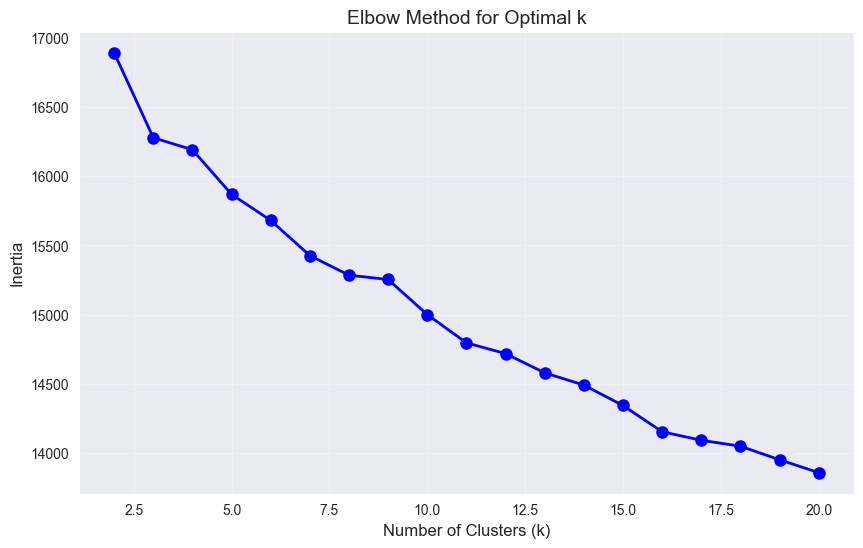

PCA Ï∞®Ïõê Ï∂ïÏÜå Ï§ë...
PCA ÏÑ§Î™Ö Î∂ÑÏÇ∞ ÎπÑÏú®: [0.06820171 0.06256888]
Ï¥ù ÏÑ§Î™Ö Î∂ÑÏÇ∞: 0.131
Ïù¥ÎØ∏ÏßÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ïï†ÎãàÎ©îÏù¥ÏÖò ÏÉùÏÑ± Ï§ë...


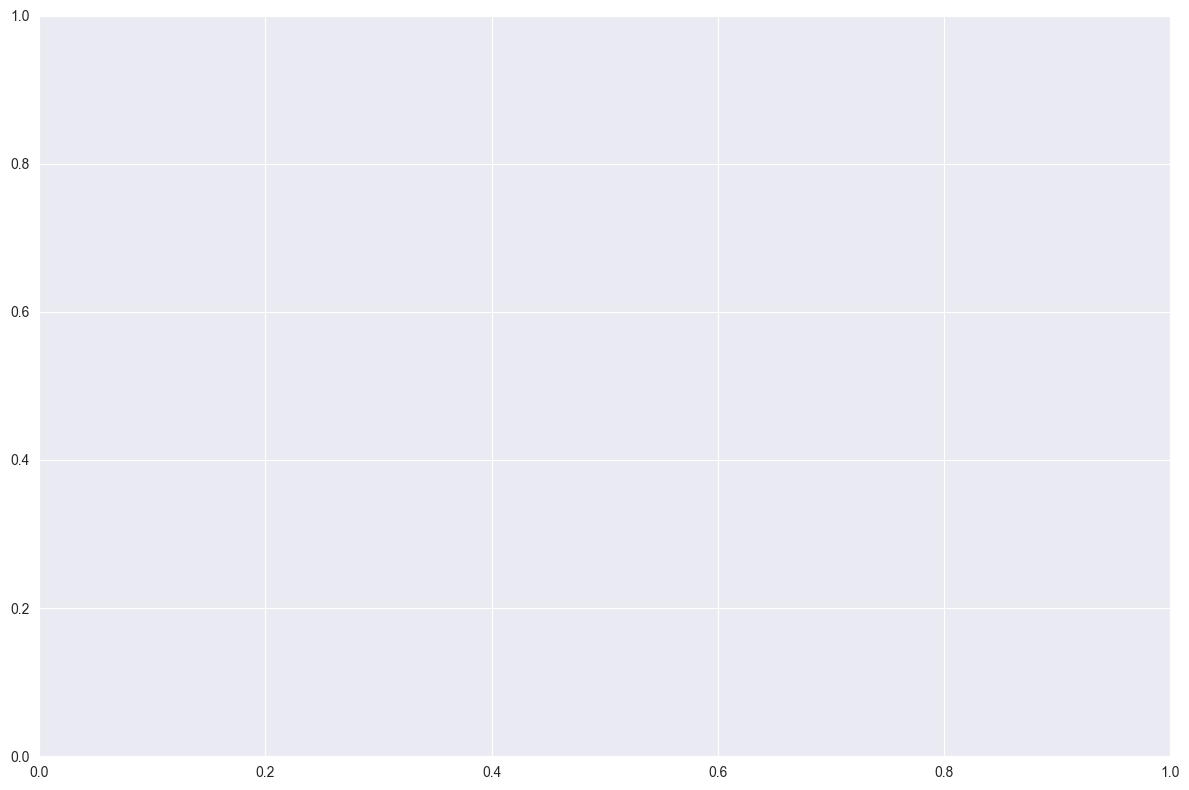

ÌÖçÏä§Ìä∏ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ïï†ÎãàÎ©îÏù¥ÏÖò ÏÉùÏÑ± Ï§ë...


C:\Users\user\miniconda3\envs\laion_env\lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


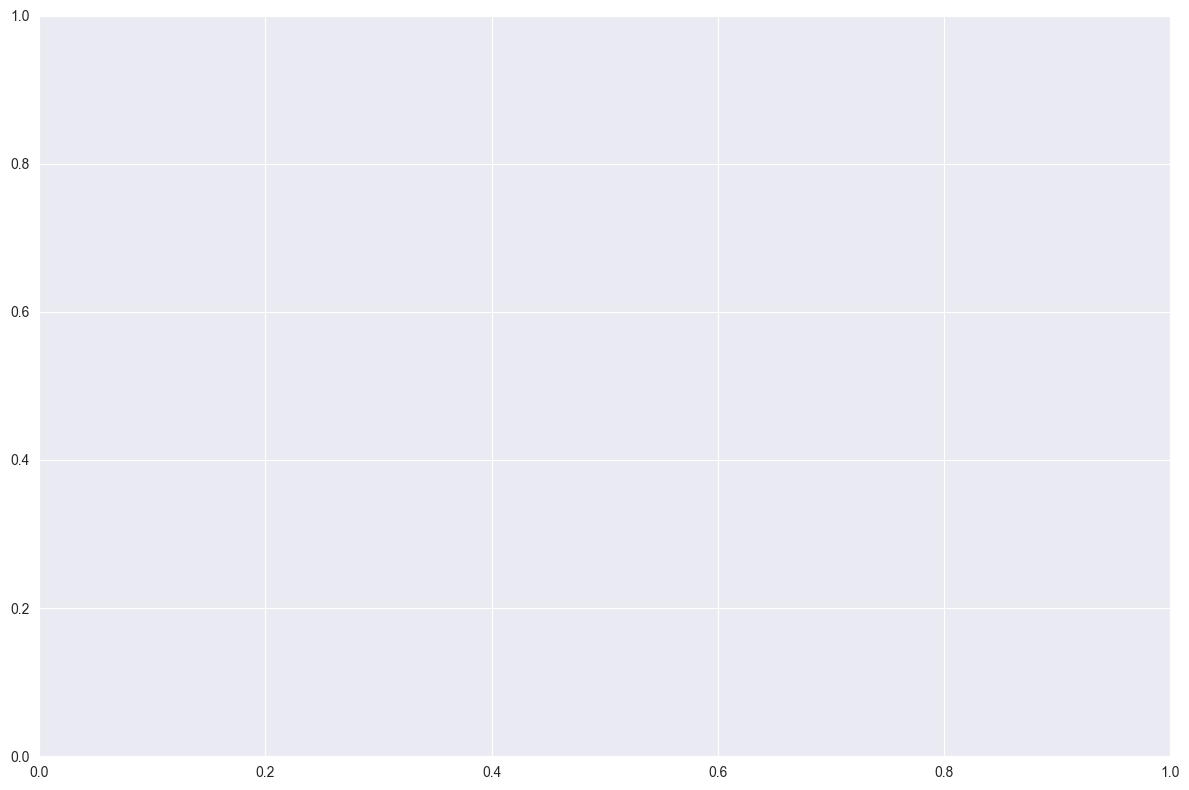

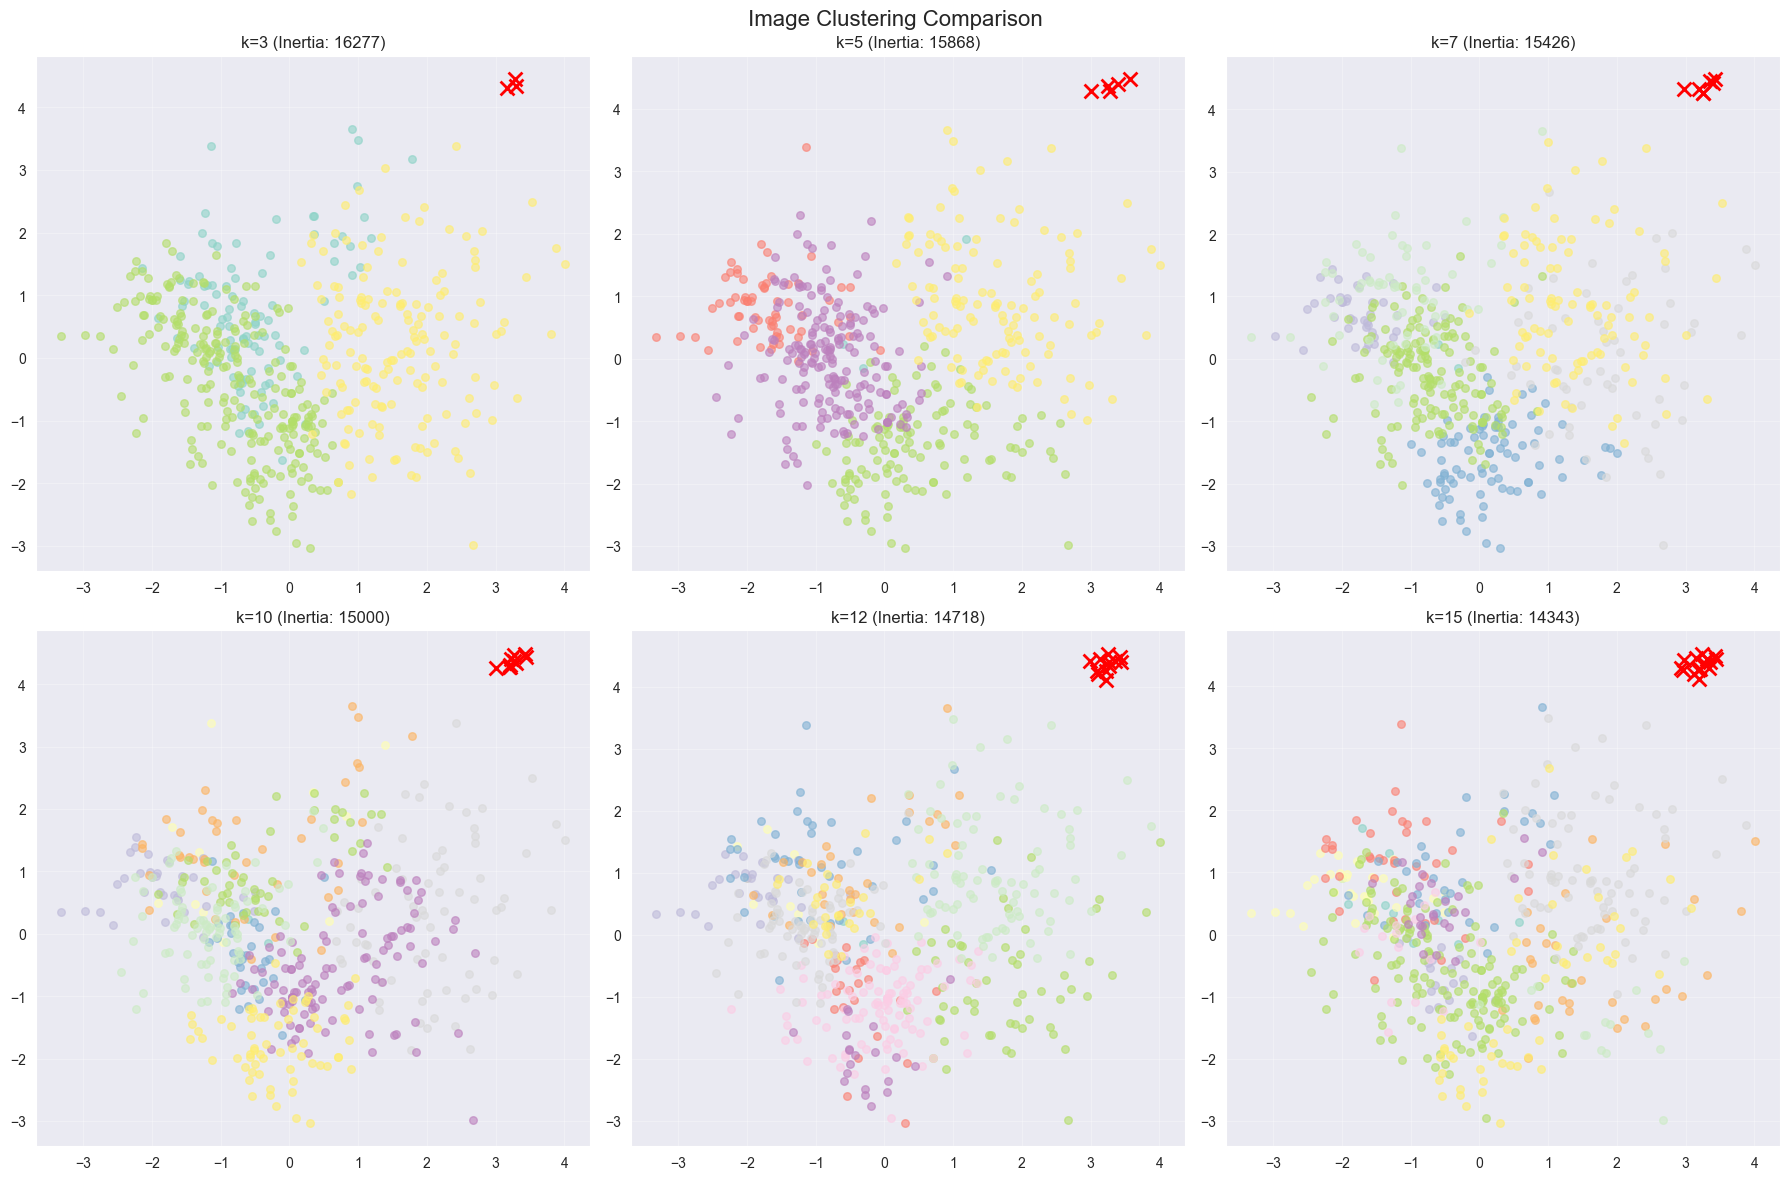


=== ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌíàÏßà ÌèâÍ∞Ä ===
k=2: Silhouette Score = 0.013
k=3: Silhouette Score = 0.025
k=4: Silhouette Score = 0.033
k=5: Silhouette Score = 0.027
k=6: Silhouette Score = 0.020
k=7: Silhouette Score = 0.020
k=8: Silhouette Score = 0.014
k=9: Silhouette Score = 0.017
k=10: Silhouette Score = 0.015


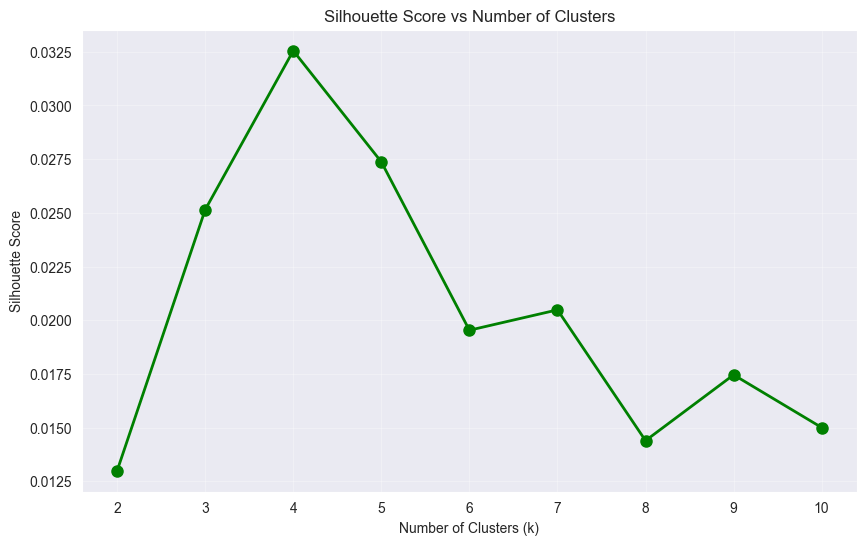


=== ÏµúÏ†Å k Ï∂îÏ≤ú ===
ÏóòÎ≥¥Ïö∞ Î∞©Î≤ï Í∏∞Ï§Ä: k = 4
Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ Í∏∞Ï§Ä: k = 4
ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏ Ïàò Í∏∞Ï§Ä: k = 5 (Í∂åÏû•)


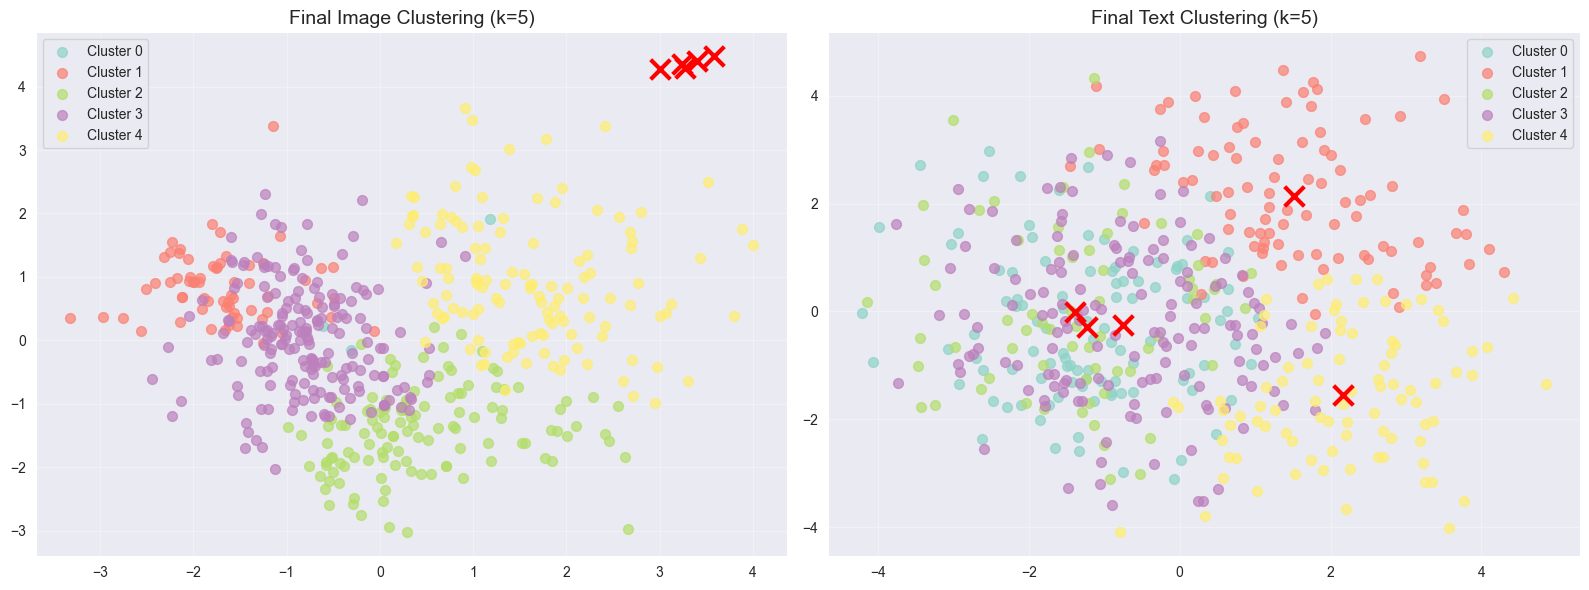


ÏµúÏ¢Ö ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ ÏôÑÎ£å! (k=5)
Ïù¥ÎØ∏ÏßÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ Î∂ÑÌè¨: [  3  65 122 187 123]
ÌÖçÏä§Ìä∏ ÌÅ¥Îü¨Ïä§ÌÑ∞ Î∂ÑÌè¨: [104  94  67 148  87]


In [83]:
# KMeans ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ ÏãúÍ∞ÅÌôî Î∞è Ïï†ÎãàÎ©îÏù¥ÏÖò
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
from IPython.display import HTML

# 1. ÏóòÎ≥¥Ïö∞ Î∞©Î≤ïÏúºÎ°ú ÏµúÏ†Å k Ï∞æÍ∏∞
print("ÏóòÎ≥¥Ïö∞ Î∞©Î≤ïÏúºÎ°ú ÏµúÏ†Å k Ï∞æÎäî Ï§ë...")
inertias = []
k_range = range(2, 21)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(image_reps)
    inertias.append(kmeans.inertia_)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}")

# ÏóòÎ≥¥Ïö∞ Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# 2. 2D ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌïú PCA Ï∞®Ïõê Ï∂ïÏÜå
print("PCA Ï∞®Ïõê Ï∂ïÏÜå Ï§ë...")
pca = PCA(n_components=2, random_state=42)
image_2d = pca.fit_transform(image_reps.numpy())
text_2d = pca.fit_transform(text_reps.numpy())

print(f"PCA ÏÑ§Î™Ö Î∂ÑÏÇ∞ ÎπÑÏú®: {pca.explained_variance_ratio_}")
print(f"Ï¥ù ÏÑ§Î™Ö Î∂ÑÏÇ∞: {pca.explained_variance_ratio_.sum():.3f}")

# 3. Îã§ÏñëÌïú kÍ∞íÏóê ÎåÄÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ ÎπÑÍµê Ïï†ÎãàÎ©îÏù¥ÏÖò
def create_clustering_animation(data, title_prefix, k_values=[3, 5, 7, 10, 15]):
    """ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥ºÎ•º Ïï†ÎãàÎ©îÏù¥ÏÖòÏúºÎ°ú Î≥¥Ïó¨Ï£ºÎäî Ìï®Ïàò"""

    fig, ax = plt.subplots(figsize=(12, 8))

    def animate(frame):
        ax.clear()
        k = k_values[frame % len(k_values)]

        # KMeans Ïã§Ìñâ
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        if title_prefix == "Image":
            labels = kmeans.fit_predict(image_reps)
            centers_2d = pca.transform(kmeans.cluster_centers_)
            data_2d = image_2d
        else:
            labels = kmeans.fit_predict(text_reps)
            centers_2d = pca.transform(kmeans.cluster_centers_)
            data_2d = text_2d

        # ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏÉâÏÉÅ ÏßÄÏ†ï
        colors = plt.cm.Set3(np.linspace(0, 1, k))

        # Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏ Í∑∏Î¶¨Í∏∞
        for i in range(k):
            cluster_points = data_2d[labels == i]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                      c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=50)

        # ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï§ëÏã¨Ï†ê Í∑∏Î¶¨Í∏∞
        ax.scatter(centers_2d[:, 0], centers_2d[:, 1],
                  c='red', marker='x', s=200, linewidths=3, label='Centroids')

        ax.set_title(f'{title_prefix} Clustering (k={k})', fontsize=16)
        ax.set_xlabel('PCA Component 1', fontsize=12)
        ax.set_ylabel('PCA Component 2', fontsize=12)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

    # Ïï†ÎãàÎ©îÏù¥ÏÖò ÏÉùÏÑ±
    anim = animation.FuncAnimation(fig, animate, frames=len(k_values)*3,
                                 interval=1500, repeat=True)
    plt.tight_layout()
    return anim

# 4. Ïù¥ÎØ∏ÏßÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ïï†ÎãàÎ©îÏù¥ÏÖò
print("Ïù¥ÎØ∏ÏßÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ïï†ÎãàÎ©îÏù¥ÏÖò ÏÉùÏÑ± Ï§ë...")
img_anim = create_clustering_animation(image_2d, "Image")
plt.show()
HTML(img_anim.to_jshtml())

# 5. ÌÖçÏä§Ìä∏ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ïï†ÎãàÎ©îÏù¥ÏÖò
print("ÌÖçÏä§Ìä∏ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ïï†ÎãàÎ©îÏù¥ÏÖò ÏÉùÏÑ± Ï§ë...")
txt_anim = create_clustering_animation(text_2d, "Text")
plt.show()

# 6. Ï†ïÏ†Å ÎπÑÍµê ÏãúÍ∞ÅÌôî (Ïó¨Îü¨ kÍ∞íÏùÑ Ìïú Î≤àÏóê)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
k_values = [3, 5, 7, 10, 12, 15]

for idx, k in enumerate(k_values):
    row = idx // 3
    col = idx % 3

    # Ïù¥ÎØ∏ÏßÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ
    img_kmeans = KMeans(n_clusters=k, random_state=42)
    img_labels = img_kmeans.fit_predict(image_reps)

    # ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏÉâÏÉÅ
    colors = plt.cm.Set3(np.linspace(0, 1, k))

    for i in range(k):
        cluster_points = image_2d[img_labels == i]
        axes[row, col].scatter(cluster_points[:, 0], cluster_points[:, 1],
                              c=[colors[i]], alpha=0.6, s=30)

    # Ï§ëÏã¨Ï†ê
    centers_2d = pca.transform(img_kmeans.cluster_centers_)
    axes[row, col].scatter(centers_2d[:, 0], centers_2d[:, 1],
                          c='red', marker='x', s=100, linewidths=2)

    axes[row, col].set_title(f'k={k} (Inertia: {img_kmeans.inertia_:.0f})')
    axes[row, col].grid(True, alpha=0.3)

plt.suptitle('Image Clustering Comparison', fontsize=16)
plt.tight_layout()
plt.show()

# 7. ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌíàÏßà ÌèâÍ∞Ä
from sklearn.metrics import silhouette_score

print("\n=== ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌíàÏßà ÌèâÍ∞Ä ===")
silhouette_scores = []

for k in range(2, 11):
    img_kmeans = KMeans(n_clusters=k, random_state=42)
    img_labels = img_kmeans.fit_predict(image_reps)
    score = silhouette_score(image_reps, img_labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.3f}")

# Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True, alpha=0.3)
plt.show()

# 8. ÏµúÏ¢Ö Í∂åÏû• kÍ∞í
best_k_elbow = k_range[np.argmax(np.diff(np.diff(inertias))) + 2]  # ÏóòÎ≥¥Ïö∞ ÏßÄÏ†ê
best_k_silhouette = np.argmax(silhouette_scores) + 2

print(f"\n=== ÏµúÏ†Å k Ï∂îÏ≤ú ===")
print(f"ÏóòÎ≥¥Ïö∞ Î∞©Î≤ï Í∏∞Ï§Ä: k = {best_k_elbow}")
print(f"Ïã§Î£®Ïó£ Ïä§ÏΩîÏñ¥ Í∏∞Ï§Ä: k = {best_k_silhouette}")
print(f"ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏ Ïàò Í∏∞Ï§Ä: k = 5 (Í∂åÏû•)")

# 9. ÏµúÏ¢Ö ÏÑ†ÌÉùÎêú kÎ°ú ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥º
final_k = 5  # ÎòêÎäî ÏúÑÏóêÏÑú Í≥ÑÏÇ∞Îêú ÏµúÏ†ÅÍ∞í ÏÇ¨Ïö©

img_kmeans_final = KMeans(n_clusters=final_k, random_state=42)
txt_kmeans_final = KMeans(n_clusters=final_k, random_state=42)

img_labels_final = img_kmeans_final.fit_predict(image_reps)
txt_labels_final = txt_kmeans_final.fit_predict(text_reps)

# ÏµúÏ¢Ö Í≤∞Í≥º ÏãúÍ∞ÅÌôî
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.Set3(np.linspace(0, 1, final_k))

# Ïù¥ÎØ∏ÏßÄ ÌÅ¥Îü¨Ïä§ÌÑ∞
for i in range(final_k):
    cluster_points = image_2d[img_labels_final == i]
    ax1.scatter(cluster_points[:, 0], cluster_points[:, 1],
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=50)

img_centers_2d = pca.transform(img_kmeans_final.cluster_centers_)
ax1.scatter(img_centers_2d[:, 0], img_centers_2d[:, 1],
           c='red', marker='x', s=200, linewidths=3)
ax1.set_title(f'Final Image Clustering (k={final_k})', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# ÌÖçÏä§Ìä∏ ÌÅ¥Îü¨Ïä§ÌÑ∞
for i in range(final_k):
    cluster_points = text_2d[txt_labels_final == i]
    ax2.scatter(cluster_points[:, 0], cluster_points[:, 1],
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=50)

txt_centers_2d = pca.transform(txt_kmeans_final.cluster_centers_)
ax2.scatter(txt_centers_2d[:, 0], txt_centers_2d[:, 1],
           c='red', marker='x', s=200, linewidths=3)
ax2.set_title(f'Final Text Clustering (k={final_k})', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nÏµúÏ¢Ö ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ ÏôÑÎ£å! (k={final_k})")
print(f"Ïù¥ÎØ∏ÏßÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ Î∂ÑÌè¨: {np.bincount(img_labels_final)}")
print(f"ÌÖçÏä§Ìä∏ ÌÅ¥Îü¨Ïä§ÌÑ∞ Î∂ÑÌè¨: {np.bincount(txt_labels_final)}")

In [84]:
k=5 # Ï†àÎ∞ò Ïà´ÏûêÎ°ú ÏùºÎã® ÏãúÏûë

img_kmeans = KMeans(n_clusters=k, random_state=42).fit(image_reps)
txt_kmeans = KMeans(n_clusters=k, random_state=42).fit(text_reps)

# ÌÖçÏä§Ìä∏ ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï§ëÏã¨ÏùÑ Ïù¥ÎØ∏ÏßÄ Ï∞®ÏõêÏúºÎ°ú Ìà¨ÏòÅ
project_txt = torch.nn.Linear(text_reps.shape[1], image_reps.shape[1], bias=False)
with torch.no_grad():
    txt_proj_centers = project_txt(torch.tensor(txt_kmeans.cluster_centers_, dtype=torch.float32)).numpy()

dist_matrix = cdist(img_kmeans.cluster_centers_, txt_proj_centers, metric='cosine')
row_ind, col_ind = linear_sum_assignment(dist_matrix)

## Cross-attention-like Î≤°ÌÑ∞ ÏÉùÏÑ±

In [85]:
paired_vectors = []
project_txt.eval()

for i, j in zip(row_ind, col_ind):
    img_cluster = image_reps[img_kmeans.labels_ == i]
    txt_cluster = text_reps[txt_kmeans.labels_ == j]

    mean_img = img_cluster.mean(dim=0)
    mean_txt = txt_cluster.mean(dim=0)
    mean_txt_proj = project_txt(mean_txt.unsqueeze(0)).squeeze(0)

    cross_attn_vec = F.normalize(mean_img + mean_txt_proj, dim=0)
    paired_vectors.append(cross_attn_vec)

In [86]:
print(f"[DEBUG] paired_vectors length: {len(paired_vectors)}")
for i, vec in enumerate(paired_vectors):
    print(f" - vector {i}: type={type(vec)}, shape={getattr(vec, 'shape', None)}")


[DEBUG] paired_vectors length: 5
 - vector 0: type=<class 'torch.Tensor'>, shape=torch.Size([512])
 - vector 1: type=<class 'torch.Tensor'>, shape=torch.Size([512])
 - vector 2: type=<class 'torch.Tensor'>, shape=torch.Size([512])
 - vector 3: type=<class 'torch.Tensor'>, shape=torch.Size([512])
 - vector 4: type=<class 'torch.Tensor'>, shape=torch.Size([512])


##  Global Update Distribution with Gating

### constant Ï†ïÏùò Î∞è ÌèâÍ∞Ä Ìï®Ïàò

In [87]:
# ÏÉÅÏàò Ï†ïÏùò
GATING_RATIO = 0.3  # Gating ÏóÖÎç∞Ïù¥Ìä∏ ÎπÑÏú® (0~1 ÏÇ¨Ïù¥)
UPDATED_MODEL_NAME = "gated_model.pt"  # ÏóÖÎç∞Ïù¥Ìä∏Îêú Î™®Îç∏ Ï†ÄÏû• Ïù¥Î¶Ñ

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            # Î≥ÄÏàò Ï¥àÍ∏∞ÌôîÎ•º Îß® ÏïûÏóê
            images = None
            texts = None
            labels = None

            try:
                if isinstance(batch, list) and len(batch) == 4:
                    images = batch[0]
                    text_input_ids = batch[1]
                    text_attention_mask = batch[2]
                    labels = batch[3]

                    texts = {
                        'input_ids': text_input_ids,
                        'attention_mask': text_attention_mask
                    }

                elif isinstance(batch, dict):
                    images = batch.get('image', None)
                    texts = batch.get('text', None)
                    labels = batch['label']
                elif len(batch) == 3:
                    images, texts, labels = batch
                elif len(batch) == 2:
                    data, labels = batch
                    images = data
                    texts = None
                else:
                    print(f"Unexpected batch structure: length={len(batch)}, types={[type(x) for x in batch]}")
                    continue

            except Exception as e:
                print(f"Error processing batch: {e}")
                continue

            # GPUÎ°ú Ïù¥Îèô
            device = next(model.parameters()).device
            if images is not None:
                images = images.to(device)
            if texts is not None:
                if isinstance(texts, dict):
                    texts = {k: v.to(device) for k, v in texts.items()}
                elif hasattr(texts, 'to'):
                    texts = texts.to(device)
            labels = labels.to(device)

            # ÏàúÏ†ÑÌåå
            try:
                has_img = hasattr(model, 'use_img') and model.use_img
                has_txt = hasattr(model, 'use_txt') and model.use_txt

                # batch_size Í≤∞Ï†ï
                if images is not None:
                    batch_size = images.size(0)
                elif texts is not None and isinstance(texts, dict):
                    batch_size = texts['input_ids'].size(0)
                else:
                    print("Warning: Cannot determine batch size")
                    continue

                # prev_z Ï¥àÍ∏∞Ìôî
                prev_z = torch.zeros(batch_size, 256).to(device)

                if has_img and has_txt and images is not None and texts is not None:
                    input_ids = texts['input_ids']
                    attention_mask = texts['attention_mask']
                    outputs, _ = model(images, input_ids, attention_mask, prev_z)

                elif has_img and images is not None:
                    outputs, _ = model(images, None, None, prev_z)

                elif has_txt and texts is not None:
                    input_ids = texts['input_ids']
                    attention_mask = texts['attention_mask']
                    outputs, _ = model(None, input_ids, attention_mask, prev_z)

                else:
                    print("Warning: No matching input modality found")
                    continue

            except Exception as e:
                print(f"Error in model forward pass: {e}")
                print(f"Model attributes: use_img={getattr(model, 'use_img', 'unknown')}, use_txt={getattr(model, 'use_txt', 'unknown')}")
                continue

            # ÏÜêÏã§ Í≥ÑÏÇ∞
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if len(data_loader) == 0 or total == 0:
        return 0.0, 0.0

    avg_loss = total_loss / len(data_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

### gating mechanism

In [88]:
from collections import OrderedDict

paired_vectors = torch.stack(list(paired_vectors)).to(device)
NUM_CLIENTS = 10
CLIENT_ROOT = 'clients'

before_acc_list = []
after_acc_list = []

for cid in range(NUM_CLIENTS):
    client_path = os.path.join(CLIENT_ROOT, f"client_{cid}")
    model_path = os.path.join(client_path, "best_model.pt")

    if not os.path.exists(model_path):
        print(f"[Í≤ΩÍ≥†] Client {cid}Ïóê best_model.pt ÏóÜÏùå")
        continue

    # ÎùºÎ≤® Í∞úÏàò Ï∂îÏ†ï
    train_dir = os.path.join(client_path, "train")
    labels = sorted([l for l in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, l))])
    label2idx = {label: idx for idx, label in enumerate(labels)}
    num_classes = len(label2idx)

    # ===== ÌïµÏã¨ ÏàòÏ†ï Î∂ÄÎ∂Ñ =====
    # Ï†ÄÏû•Îêú Î™®Îç∏ÏóêÏÑú Ïã§Ï†ú fusion_input_dim Ï∂îÏ∂ú
    saved_state = torch.load(model_path, map_location=device)
    actual_fusion_input_dim = saved_state['fc_fusion.weight'].shape[1]

    print(f"[DEBUG] Client {cid}: Ï†ÄÏû•Îêú Î™®Îç∏Ïùò Ïã§Ï†ú fusion_input_dim = {actual_fusion_input_dim}")

    # use_img/use_txt ÏÑ§Ï†ï
    use_img = (cid not in [2, 3])
    use_txt = (cid not in [0, 1])

    # Ïã§Ï†ú Ï∞®ÏõêÏúºÎ°ú Î™®Îç∏ ÏÉùÏÑ±
    model = FusionClassifier(actual_fusion_input_dim, 256, num_classes,
                             use_img=use_img, use_txt=use_txt).to(device)

    # Ïù¥Ï†ú Ï∞®ÏõêÏù¥ ÎßûÏúºÎØÄÎ°ú Ï†ïÏÉÅ Î°úÎìúÎê®
    model.load_state_dict(saved_state)
    # ========================

    # ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏ Î°úÏª¨ validation Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú ÌèâÍ∞Ä
    val_dir = os.path.join(client_path, "val")
    val_ds = MultiModalDataset(
        root=val_dir,
        tokenizer=AutoTokenizer.from_pretrained("prajjwal1/bert-tiny"),
        transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]),
        label2idx=label2idx
    )
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16)

    criterion = torch.nn.CrossEntropyLoss()

    _, before_acc = evaluate(model, val_loader, criterion)
    before_acc_list.append(before_acc)

    # Gating ÏóÖÎç∞Ïù¥Ìä∏
    updated_state = OrderedDict()
    global_rep = paired_vectors[cid % len(paired_vectors)]

    for name, param in model.state_dict().items():
        if name.endswith("fc_fusion.weight") or name.endswith("input_gate.weight"):
            out_dim, in_dim = param.shape
            projected = global_rep[:out_dim].unsqueeze(1).expand(out_dim, in_dim)
            updated_param = (1 - GATING_RATIO) * param + GATING_RATIO * projected
        else:
            updated_param = param
        updated_state[name] = updated_param

    model.load_state_dict(updated_state)
    _, after_acc = evaluate(model, val_loader, criterion)
    after_acc_list.append(after_acc)

    torch.save(updated_state, os.path.join(client_path, UPDATED_MODEL_NAME))
    print(f"Client {cid}: Updated (Before={before_acc:.4f}, After={after_acc:.4f})")


C:\Users\user\AppData\Local\Temp\ipykernel_30620\1809677251.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(model_path, map_location=device)
C:

[DEBUG] Client 0: Ï†ÄÏû•Îêú Î™®Îç∏Ïùò Ïã§Ï†ú fusion_input_dim = 576
Client 0: Updated (Before=97.3333, After=94.6667)
[DEBUG] Client 1: Ï†ÄÏû•Îêú Î™®Îç∏Ïùò Ïã§Ï†ú fusion_input_dim = 576
Client 1: Updated (Before=80.0000, After=74.6667)
[DEBUG] Client 2: Ï†ÄÏû•Îêú Î™®Îç∏Ïùò Ïã§Ï†ú fusion_input_dim = 128
Client 2: Updated (Before=94.6667, After=93.3333)
[DEBUG] Client 3: Ï†ÄÏû•Îêú Î™®Îç∏Ïùò Ïã§Ï†ú fusion_input_dim = 128
Client 3: Updated (Before=90.6667, After=90.6667)
[DEBUG] Client 4: Ï†ÄÏû•Îêú Î™®Îç∏Ïùò Ïã§Ï†ú fusion_input_dim = 704
Client 4: Updated (Before=84.0000, After=89.3333)
[DEBUG] Client 5: Ï†ÄÏû•Îêú Î™®Îç∏Ïùò Ïã§Ï†ú fusion_input_dim = 704
Client 5: Updated (Before=93.3333, After=82.6667)
[DEBUG] Client 6: Ï†ÄÏû•Îêú Î™®Îç∏Ïùò Ïã§Ï†ú fusion_input_dim = 704
Client 6: Updated (Before=85.3333, After=72.0000)
[DEBUG] Client 7: Ï†ÄÏû•Îêú Î™®Îç∏Ïùò Ïã§Ï†ú fusion_input_dim = 704
Client 7: Updated (Before=96.0000, After=96.0000)
[DEBUG] Client 8: Ï†ÄÏû•Îêú Î™®Îç∏Ïùò Ïã§Ï†ú fusion_inpu

## ÏãúÍ∞ÅÌôî

In [89]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [90]:
import matplotlib.pyplot as plt

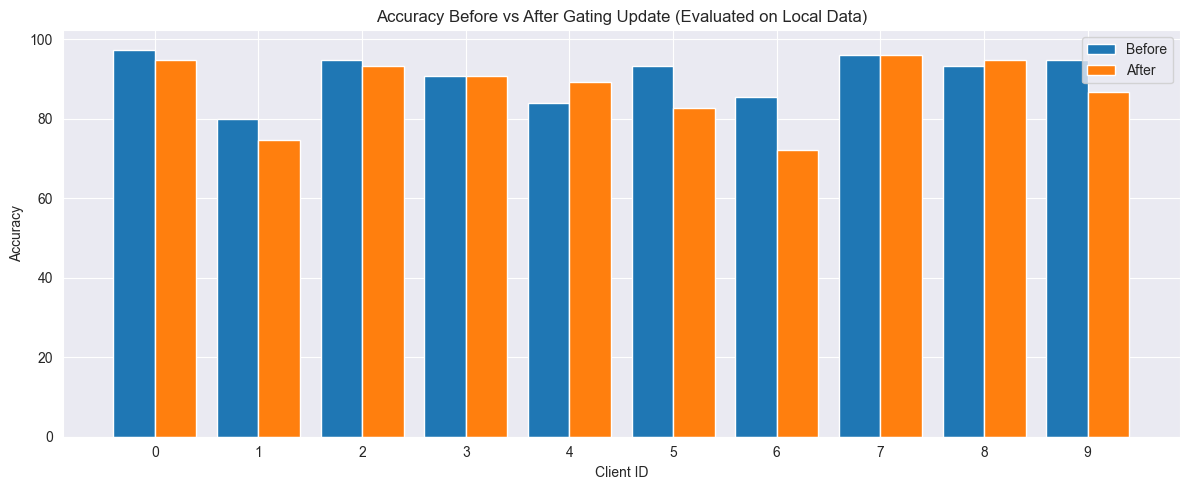

In [91]:
plt.figure(figsize=(12, 5))
x = list(range(NUM_CLIENTS))
plt.bar([i - 0.2 for i in x], before_acc_list, width=0.4, label="Before")
plt.bar([i + 0.2 for i in x], after_acc_list, width=0.4, label="After")
plt.xticks(x)
plt.xlabel("Client ID")
plt.ylabel("Accuracy")
plt.title("Accuracy Before vs After Gating Update (Evaluated on Local Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()